# Multicollinearity

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-martyn/website/blob/master/input/multicollinearity/multicollinearity.ipynb)

This question came up recently:

> In a linear regression, if you have two collinear predictors, what will happen to the coefficients if you use an L1 penalty? What about an L2 penalty?

Or in other words: How will a lasso regression model treat collinear features? Will a ridge regression behave differently?

I have an intuition here, but I'm not confident so let's try it.

## My intuition

In the L1 setting: One of the coefficients will go to zero.

In the L2 setting: One of the coefficients will *tend* to zero but will retain some small value.

Because the lasso model, with L1 penalty, is able to totally ignore one of the collinear features it will likely perform slightly better.


## What's in the textbook?

Section 6.4.4 (p243) in [An Introduction to Statistical Learning](https://www-bcf.usc.edu/~gareth/ISL/) seems to suggest that, where features are collinear, regularised models will tend to choose one and suppress the other. The authors don't make a distinction between lasso and ridge models in context of collinearity.

## Let's try it

Perhaps I should have titled this post "Collinearity" because the original question only concerns two collinear features. It's easier to reason in this simple setting so the experiments here stick to two collinear features, `x1` and `x2`.

First import dependencies and setup some functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model

In [83]:
# Set up some convenience functions

def fit_lasso(X, y, X_test):
    """
    Fit lasso with L1 penalty
    """
    model = linear_model.Lasso(alpha=1.0, fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X_test)
    R2 = model.score(X, y)
    return (y_pred, model.coef_, R2)
    
def fit_ridge(X, y, X_test):
    """
    Fit ridge regression with L2 penalty
    """
    model = linear_model.Ridge(alpha=1.0, fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X_test)
    R2 = model.score(X, y)
    return (y_pred, model.coef_, R2)

def plot(X, y, lasso_result, ridge_result):
    plt.scatter(X[:,0], y, label='x1')
    plt.scatter(X[:,1], y, label='x2')
    plt.plot(X_test[:,0], lasso_result[0], 'g--', label='lasso')
    plt.plot(X_test[:,0], ridge_result[0], 'r--', label='ridge')
    plt.ylabel('y')
    plt.xlabel('X')
    plt.legend()
    plt.show();

### Experiment A

Here feature `x2` is collinear with `x1` with a collinear gradient > 1.

In [76]:
# Simulate dataset with 2 collinear predictors
collinear_grad = 2

x1 = np.arange(-4, 4, .1)
# x2 is derived from x1 with noise
x2 = collinear_grad*x1 + 10 + np.random.randn(80)*1.0
# y1 is derived from x1 with noise
y = x1 + np.random.randn(80)*0.1
X = np.asarray([x1, x2]).T

# A grid of test values used to plot predictions
X_test = np.asarray([np.arange(-5, 20, 0.01), np.arange(-5, 20, 0.01)]).T

A quick pairplot to check `x1` and `x2` are collinear. We can verify this in row 1, column 2, where we see the two feature correlate when plotted against each other.

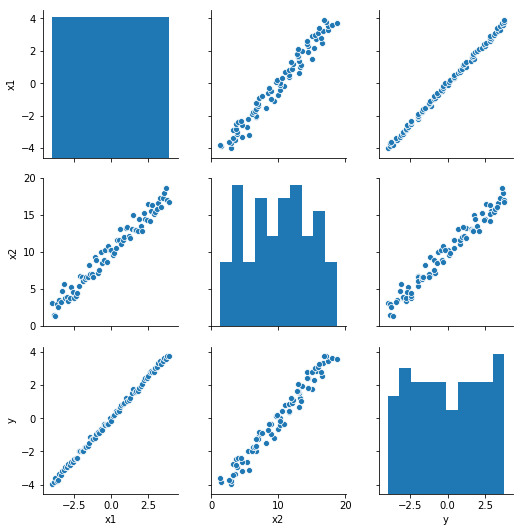

In [77]:
# Pair Plot
df = pd.DataFrame({'x1': x1, 'x2': x2, 'y':y})
sns.pairplot(df)

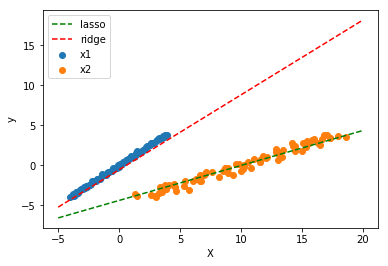

,model,$β_1$,$β_2$,$R^2$
0,lasso,0.000000,0.436947,0.961562
1,ridge,0.878228,0.057141,0.997895


In [87]:
# Fit lasso and regression models
lasso_result = fit_lasso(X, y, X_test)
ridge_result = fit_ridge(X, y, X_test)

# Display results
plot(X, y, lasso_result, ridge_result)
pd.DataFrame({
    'model': ['lasso', 'ridge'], 
    '$β_1$': [lasso_result[1][0], ridge_result[1][0]],
    '$β_2$': [lasso_result[1][1], ridge_result[1][1]],
    '$R^2$': [lasso_result[2], ridge_result[2]],
})

The lasso selects `x2` and gives the causal feature `x1` a zero coefficient. The ridge puts most weight on `x1` and gives `x2` a low coefficient close to zero.

The ridge achieves a better fit to the data with 0.998 being the proportion of variance explained, compared to 0.962 for the lasso.

Note: I'm plotting both features,`x1` and `x2`, on the same axis here which is slightly misleading as it is really a two-dimensional model. I did try a contour plot but found it was confusing and much more code.

### Experiment B

Repeat experiment A with collinear grad < 1

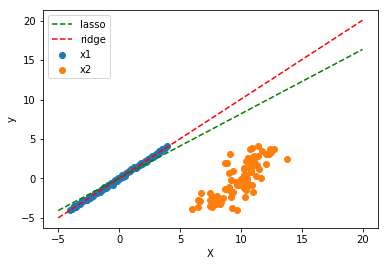

,model,$β_1$,$β_2$,$R^2$
0,lasso,0.818898,0.000000,0.963288
1,ridge,1.003192,0.001625,0.997926


In [89]:
collinear_grad = 0.6

# Generate data
x1 = np.arange(-4, 4, .1)
x2 = collinear_grad*x1 + 10 + np.random.randn(80)*1.0
y = x1 + np.random.randn(80)*0.1
X = np.asarray([x1, x2]).T

# Fit lasso and regression models
lasso_result = fit_lasso(X, y, X_test)
ridge_result = fit_ridge(X, y, X_test)

# Display results
plot(X, y, lasso_result, ridge_result)
pd.DataFrame({
    'model': ['lasso', 'ridge'], 
    '$β_1$': [lasso_result[1][0], ridge_result[1][0]],
    '$β_2$': [lasso_result[1][1], ridge_result[1][1]],
    '$R^2$': [lasso_result[2], ridge_result[2]],
})

The lasso selects `x1` and ignores `x2` with zero coefficient. The ridge puts most weight on `x1` and gives `x2` a low coefficient close to zero. The ridge model achieves a better fit to the data with a higher proportion of variance explained.

### Experiment C

Repeat experiment with collinear grad close to 1

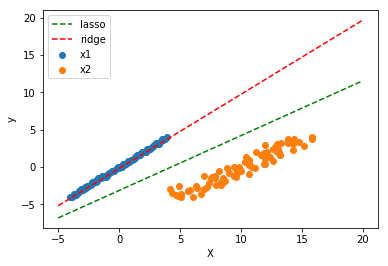

,model,$β_1$,$β_2$,$R^2$
0,lasso,0.424231,0.309282,0.948400
1,ridge,0.973374,0.019241,0.998139


In [95]:
collinear_grad = 1.2

# Generate data
x1 = np.arange(-4, 4, .1)
x2 = collinear_grad*x1 + 10 + np.random.randn(80)*1.0
y = x1 + np.random.randn(80)*0.1
X = np.asarray([x1, x2]).T

# Fit lasso and regression models
lasso_result = fit_lasso(X, y, X_test)
ridge_result = fit_ridge(X, y, X_test)

# Display results
plot(X, y, lasso_result, ridge_result)
pd.DataFrame({
    'model': ['lasso', 'ridge'], 
    '$β_1$': [lasso_result[1][0], ridge_result[1][0]],
    '$β_2$': [lasso_result[1][1], ridge_result[1][1]],
    '$R^2$': [lasso_result[2], ridge_result[2]],
})

The ridge behaves much as before putting most weight on `x1` and giving `x2` a low coefficient close to zero. The lasso puts significant weight on both `x1` and `x2`.

The ridge achieves a superior fit to the data with a higher proportion of variance explained.

## Conclusion

**Tentative conclusions as these experiments are brief, and certainly not exhaustive.**

In a linear regression, if you have two collinear predictors, an L1 penalty (lasso) will cause one of the coefficients to go to zero. Which coefficient is zeroed seems to be related to the gradient of the collinearity between features. If this gradient is about some threshold then neither coefficient will be zeroed and the models fit is degraded.


An L2 penalty (ridge regression) also suppresses one of the coefficients, but not totally to zero. In this case the gradient of collinearity has no effect on which coefficient is suppressed.

The results imply that when two features are used and both are collinear then the L2 penalty will provide a better fit to the data. An L2 penalty is also more robust with respect to the gradient of collinearity between features. It's not known if this result generalises to the case where the number of features p > 2.
